In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Read inall the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [3]:
# build vocabulary of characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [43]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next
# def build_dataset(words):
X, Y = [], []
for w in words:
    context = [0] * block_size # initial context is all '.'
    for ch in w + '.': # we add the '.' to the end of each word
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)
    # return X, Y

In [9]:
C = torch.randn((27, 2)) # character embeddings

In [10]:
emb = C[X] # embed the characters into vectors
emb.shape

torch.Size([32, 3, 2])

In [11]:
W1 = torch.randn((6, 100)) # hidden layer
b1 = torch.randn(100)

In [12]:
torch.cat(torch.unbind(emb, dim=1), 1).shape

torch.Size([32, 6])

In [22]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # affine layer

In [23]:
h

tensor([[ 0.7384, -0.9993, -0.9975,  ...,  0.9942,  0.0694,  0.9923],
        [ 0.5976, -0.9848, -0.9699,  ...,  0.9991,  0.8500,  0.9988],
        [-0.9019,  0.1767, -0.9999,  ...,  0.9998,  0.9995,  0.9996],
        ...,
        [ 0.3961, -0.9283, -0.5351,  ..., -0.9894,  0.9719,  0.9876],
        [ 0.4664,  0.7673,  0.1529,  ..., -0.9409,  0.4654, -0.7700],
        [-0.6606, -0.6302, -0.6917,  ...,  0.5309,  0.9218,  0.9736]])

In [25]:
W2 = torch.randn((100, 27)) # output layer
b2 = torch.randn(27)

In [26]:
logits = h @ W2 + b2 # affine layer
logits.shape

torch.Size([32, 27])

In [27]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [30]:
probs[torch.arange(32),Y]

tensor([1.7762e-17, 1.1862e-10, 5.5953e-09, 9.8490e-01, 1.9570e-08, 3.1819e-12,
        3.0292e-11, 1.6492e-16, 6.7312e-05, 1.4413e-11, 9.9999e-01, 2.1480e-04,
        9.9457e-01, 1.3118e-09, 1.5855e-02, 3.7040e-14, 7.9818e-14, 4.9028e-14,
        8.4581e-02, 6.4906e-08, 2.3741e-10, 3.3917e-09, 8.9976e-06, 9.9230e-01,
        1.4803e-07, 7.6687e-21, 2.1051e-07, 2.5428e-09, 4.7212e-09, 6.5432e-05,
        8.6814e-01, 8.5512e-07])

In [31]:
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(17.4065)

In [32]:
# Summarize the codes above

In [47]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [73]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # character embeddings
W1 = torch.randn((6, 100), generator=g) # hidden layer
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) # output layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters)

3481

In [55]:
emb = C[X] # embed the characters into vectors
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
logits = h @ W2 + b2 # output layer
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32),Y].log().mean()
loss = F.cross_entropy(logits, Y) # more numerically stable
loss

tensor(19.5052, grad_fn=<NllLossBackward0>)

In [74]:
for p in parameters:
    p.requires_grad = True

In [75]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [83]:
lri = []
lossi = []

for i in range(10000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,)) # batch

    # Forward pass
    emb = C[X[ix]] # embed the characters into vectors
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y[ix]) # more numerically stable
    # print(loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update
    # lri = lrs[i] 
    lr = 0.01
    for p in parameters:
        p.data += -0.1 * p.grad
    
    # Track stats
    # lri.append(lre[i].item())
    # lossi.append(loss.item())
print(loss.item())



2.532382011413574


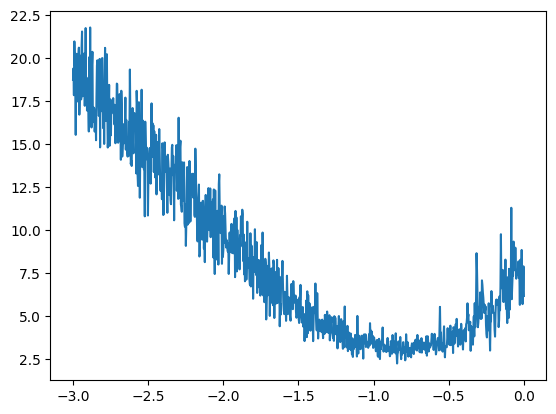

In [71]:
plt.plot(lri, lossi)

In [ ]:
torch.randint(0, 27, (block_size,))

In [90]:
# training split, validation split, test split
# 80%, 10%, 10%

# build the dataset
# 

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # initial context is all '.'
        for ch in w + '.': # we add the '.' to the end of each word
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42) # make the randomization repeatable
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape



(torch.Size([182580, 3]),
 torch.Size([182580]),
 torch.Size([22767, 3]),
 torch.Size([22767]),
 torch.Size([22799, 3]),
 torch.Size([22799]))

In [91]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [130]:
g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((27, 2), generator=g) # character embeddings
C = torch.randn((27, 10), generator=g) # character embeddings
W1 = torch.randn((30, 200), generator=g) # hidden layer
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # output layer
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [131]:
sum(p.nelement() for p in parameters)

11897

In [132]:
for p in parameters:
    p.requires_grad = True

In [133]:
lri = []
lossi = []
stepi = []

In [134]:
for i in range(200000):
    # mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (32,)) # batch

    # Forward pass
    emb = C[Xtr[ix]] # embed the characters into vectors
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr[ix]) # more numerically stable
    # print(loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update
    # lri = lrs[i] 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    # lri.append(lre[i].item())
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())



2.2091314792633057


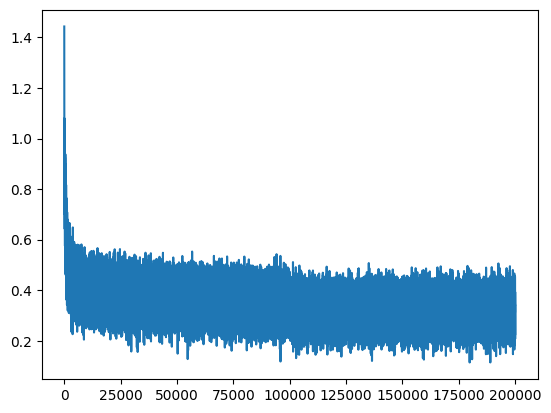

In [135]:
plt.plot(stepi, lossi)

In [136]:
emb = C[Xdev] # embed the characters into vectors
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # hidden layer
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Ydev) # more numerically stable
loss

tensor(2.1698, grad_fn=<NllLossBackward0>)

In [137]:
emb = C[Xte] # embed the characters into vectors
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # hidden layer
logits = h @ W2 + b2 # output layer
loss = F.cross_entropy(logits, Yte) # more numerically stable
loss

tensor(2.1694, grad_fn=<NllLossBackward0>)

In [138]:
# sample from the model and generate names
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initial context is all '.'
    while True:
        emb = C[torch.tensor([context])] # embed the characters into vectors
        h = torch.tanh(emb.view(-1,30) @ W1 + b1) # hidden layer
        logits = h @ W2 + b2 # output layer
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # crop and append
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carman.
ambrilli.
kimrri.
taty.
salaysa.
jazhuen.
deliah.
jarqui.
nellara.
chaiir.
kaleigh.
ham.
jori.
quint.
sulin.
alian.
quin.
elo.
dearyni.
jaxen.


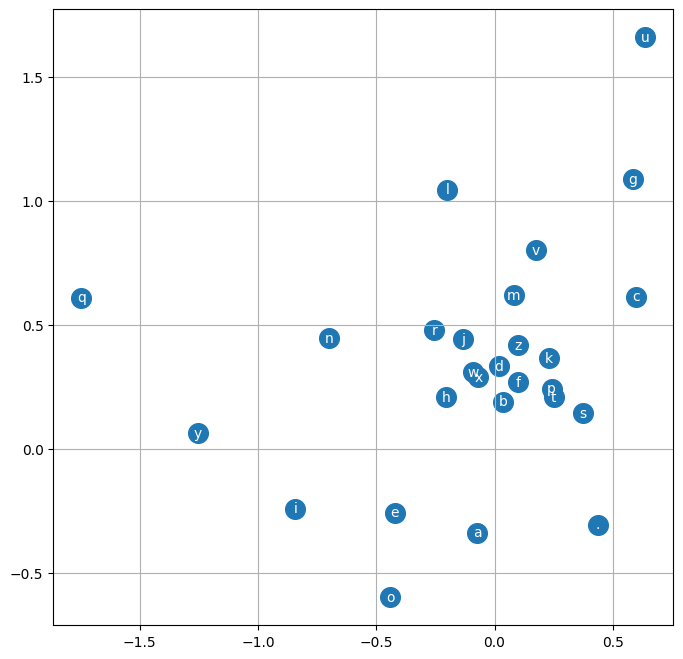

In [117]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')